In [ ]:
from lyutool import *

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import laspy as las
from scipy.spatial.kdtree import KDTree
import numpy as np
import scipy
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
def show(points, rgb):
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_axes([0,0,1,1],projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=rgb)
    ax.view_init(azim = 180+40,elev = 30) 
    return ax

In [ ]:
las_fp = pathlib.Path('testdata/t_remain.las')
inFile = las.file.File(las_fp, mode='r')
classification = inFile.classification
xyz = np.vstack([inFile.x, inFile.y, inFile.z]).transpose()
xyz_min = np.min(xyz, axis=0)
xyz_max = np.max(xyz, axis=0)
rgb = (xyz[:,2] - xyz_min[2]) / (xyz_max[2] - xyz_min[2])
#
lp_xyz = LPoints(xyz)

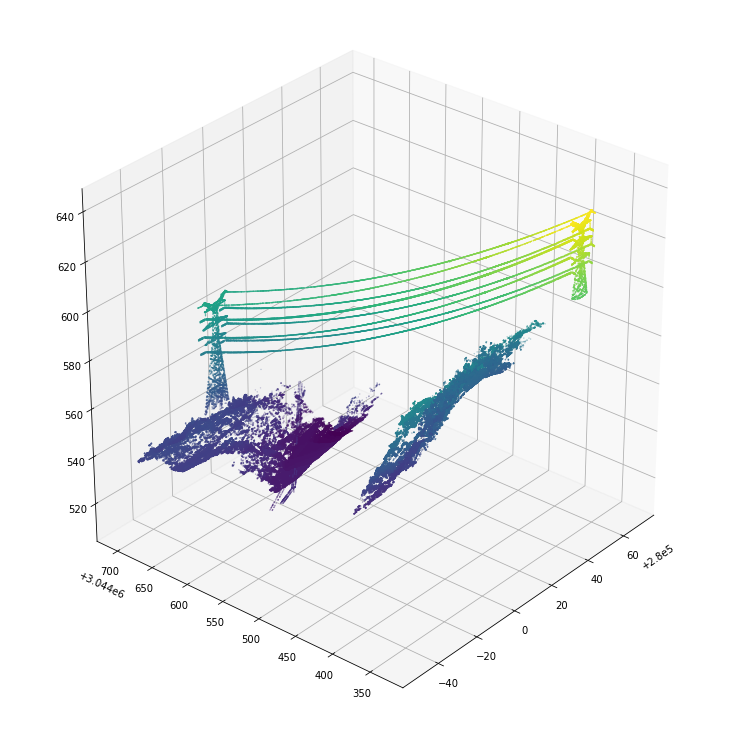

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz.T), s= 0.1, c=rgb)
ax.view_init(azim = 180+40,elev = 30) 
plt.show()

In [ ]:
# Record the index information of each category
idx = classification == 1
lp_1 = generateLPByIDS(idx)
idx = classification == 10
lp_10 = generateLPByIDS(idx)
idx = classification == 11
lp_11 = generateLPByIDS(idx)
idx = classification == 19
lp_19 = generateLPByIDS(idx)
#
tree = KDTree(xyz)
pca = PCA(n_components=3)

In [ ]:
features = []
n = 50
for i in tqdm(range(xyz.shape[0])):
    di = tree.query(xyz[i], k=n)
    pts = xyz[di[1]]
    pca.fit(pts)
    a = {'points': pts, 'pca': pca}
    fts = extractFeathersByPointCloud(**a)
    r = fts['radius']
    al = fts['axis']
    sp = fts['sphericity']
    ln = fts['linearity']
    pl = fts['planarity']
    # add Height information
    height = abs(xyz[i][2] - xyz_min[2])
    features.append([r, al, sp, ln, pl, height])
#
features = np.array(features)
features.shape

100%|██████████| 259496/259496 [08:11<00:00, 527.86it/s]


(259496, 6)

> use the dataset including sphericity, planarity and linearity to train GMM classifer. Supposed to be two classes: line and non-line, GMM divided dataset into 2 classes.

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
cov_type = 'full'
n_classes = 2
gm = GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=120, random_state=0)
#
gm.fit(features)
y_train_pred = gm.predict(features)

In [ ]:
lp_c0 = generateLPByIDS(y_train_pred == 0)
lp_c1 = generateLPByIDS(y_train_pred == 1)

kwargs = {'LP': lp_c0, 'POINTS':xyz}
pts_0 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_c0, 'POINTS':rgb}
rgb_0 = getPointsFromSource(**kwargs)

kwargs = {'LP': lp_c1, 'POINTS':xyz}
pts_1 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_c1, 'POINTS':rgb}
rgb_1 = getPointsFromSource(**kwargs)
f'pts_0:{pts_0.shape[0]}, pts_1:{pts_1.shape[0]}'

'pts_0:26545, pts_1:232951'

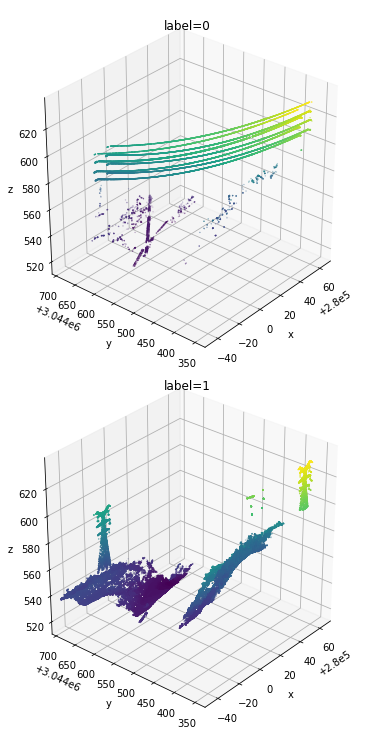

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0.5,0.5,0.5], projection='3d')
ax.scatter(*(pts_0.T), s= 0.1, c=rgb_0)
ax.view_init(azim = 180+40,elev = 30) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('label=0')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])

ax = fig.add_axes([0,0,0.5,0.5], projection='3d')
ax.scatter(*(pts_1.T), s= 0.1, c=rgb_1)
ax.view_init(azim = 180+40,elev = 30) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('label=1')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

> Project all points on the XOY plane

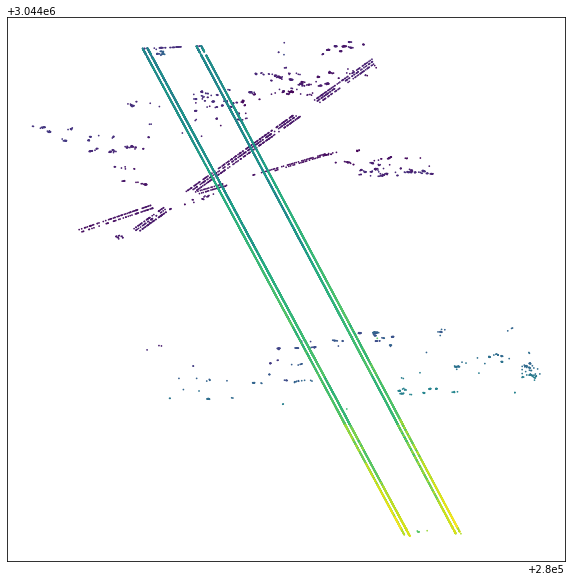

In [ ]:
sides = ('left', 'right', 'top', 'bottom')
nolabels = {s: False for s in sides}
nolabels.update({'label%s' % s: False for s in sides})
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(*zip(pts_0[:,0:2].T), s=0.5, c= rgb_0)
ax.tick_params(axis='both', which='both', **nolabels)
plt.show()

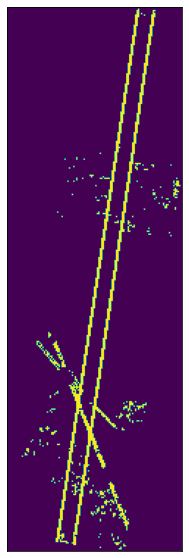

In [ ]:
a = {'xyz_min': xyz_min,
     'xyz_max': xyz_max,
     'points' : pts_0,
     'cellsize': 1,
     'HF_peaks_threshold': 48,
     'maxdist': 1,
     'discontinuity_threshold': 70,
     'buffer_size': 2
    }
rtn = constructCorridorsByHT(**a)
img_xy = rtn['img_xy']
img_corridors = rtn['img_corridors']
img_base = rtn['img_base']
lid = rtn['discontinuity']
img_lines = rtn['img_lines']
corridors = rtn['corridors'] 
hl = rtn['hough_lines']
#
# the original raster image generated from the points cloud with self-defined cell size.
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_xy)
plt.show()

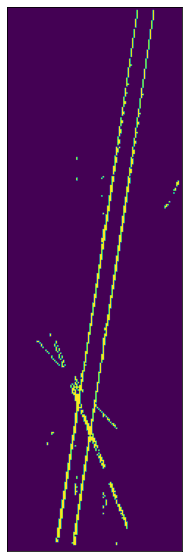

In [ ]:
# filter the short lines based on hough peaks and raster image img_xy
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_base)
plt.show()

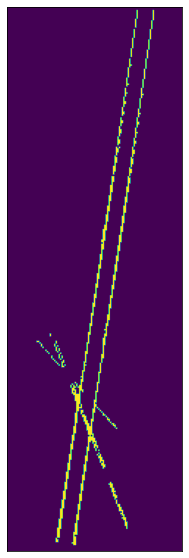

In [ ]:
# remove the lines with long discontinuity
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_lines)
plt.show()

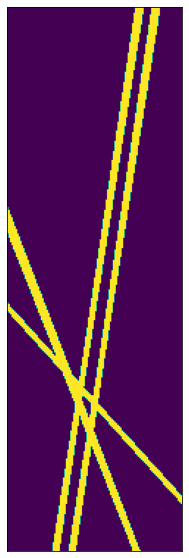

In [ ]:
# construct corridors based on img_temp and buffer operation
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)
plt.show()

In [ ]:
# test
len(corridors)

7

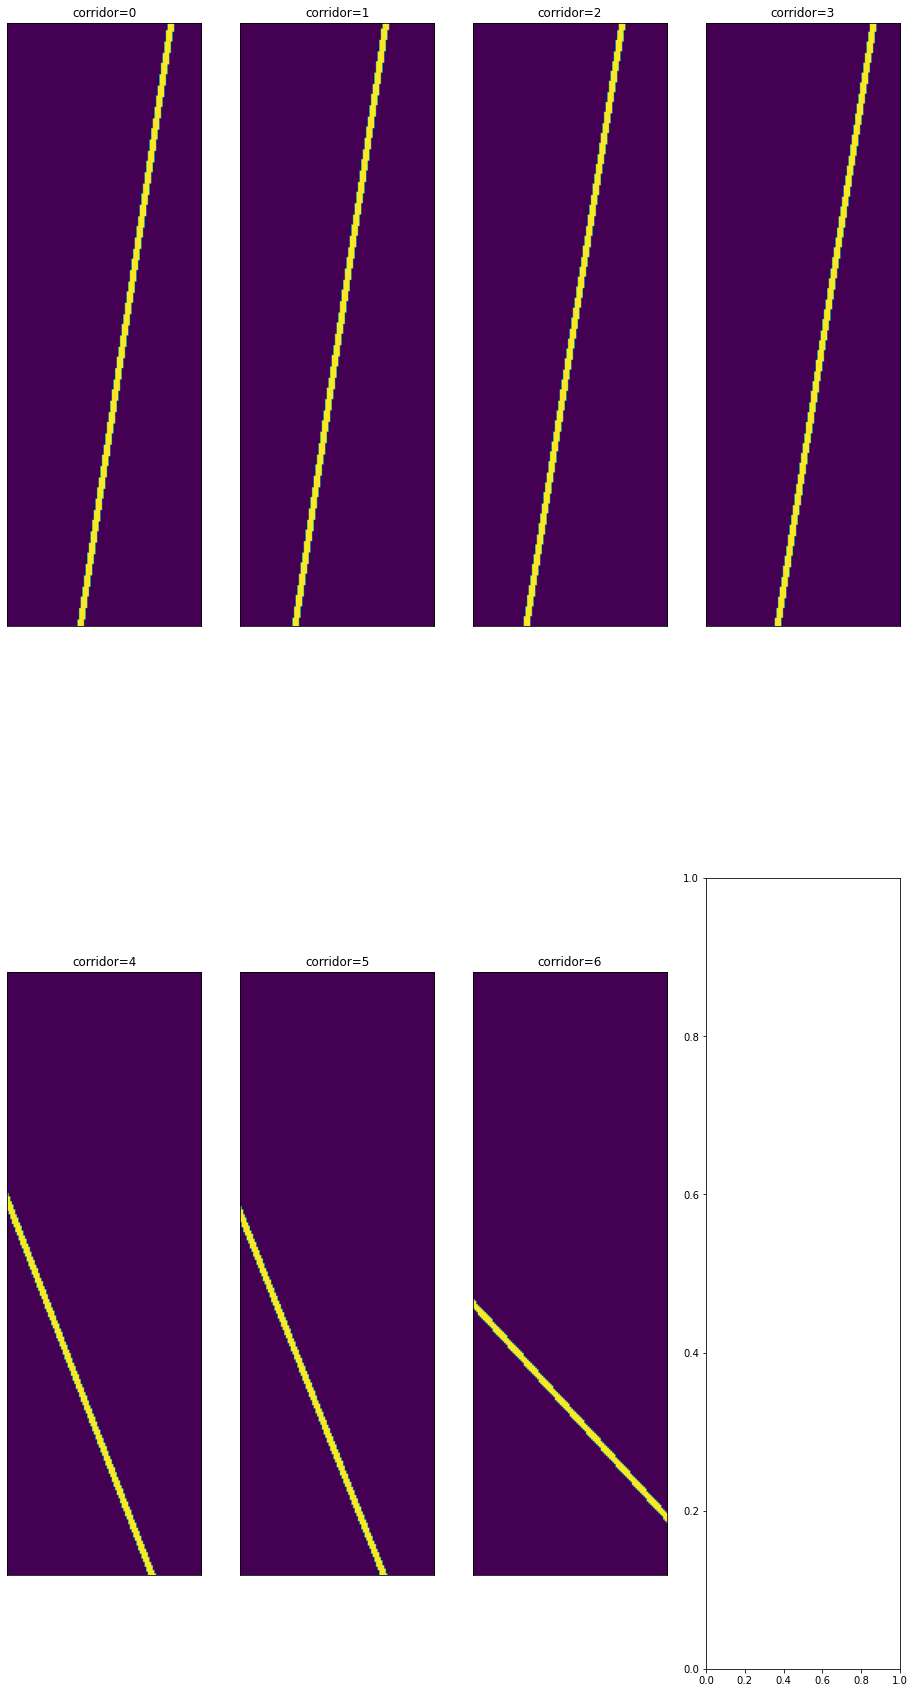

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,32))
axs = axs.ravel()
for i in range(7):
    axs[i].tick_params(axis='both', which='both', **nolabels)
    axs[i].imshow(corridors[i])
    axs[i].set_title(f'corridor={i}')
plt.show()

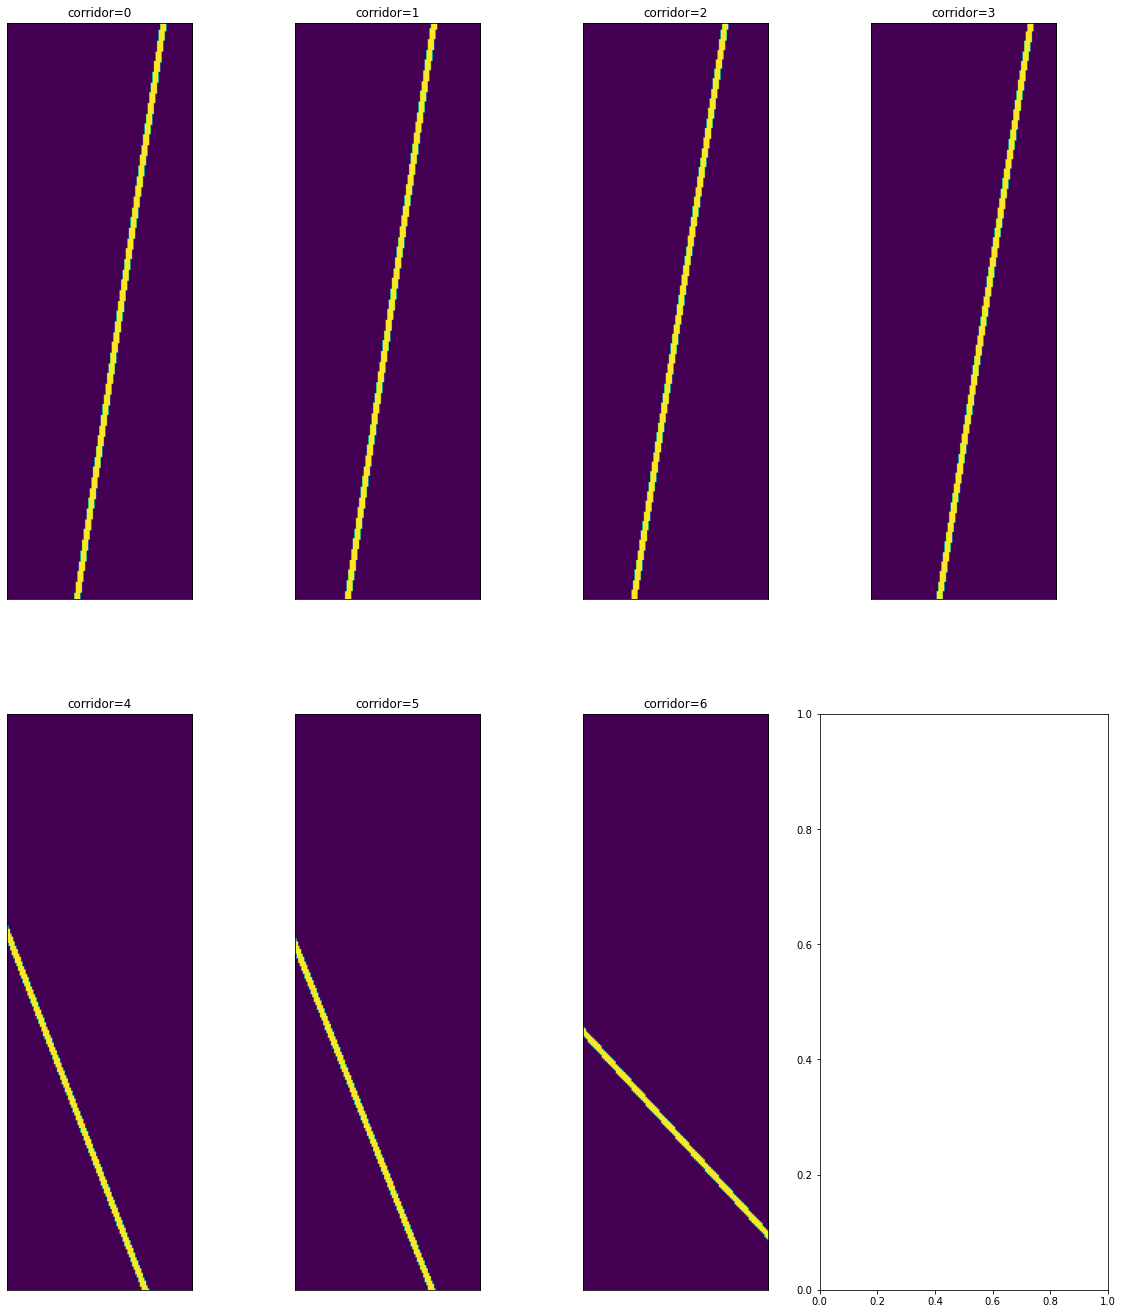

In [ ]:
fig = plt.figure(figsize=(16,32))
ax0 = fig.add_axes([0,0.3,0.25,0.25])
ax1 = fig.add_axes([0.25,0.3,0.25,0.25])
ax2 = fig.add_axes([0.5,0.3,0.25,0.25])
ax3 = fig.add_axes([0.75,0.3,0.25,0.25])
#
ax4 = fig.add_axes([0,0,0.25,0.25])
ax5 = fig.add_axes([0.25,0,0.25,0.25])
ax6 = fig.add_axes([0.5,0,0.25,0.25])
ax7 = fig.add_axes([0.75,0,0.25,0.25])
#
axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
for i in range(7):
    axs[i].tick_params(axis='both', which='both', **nolabels)
    axs[i].imshow(corridors[i])
    axs[i].set_title(f'corridor={i}')
#
plt.show()

> by analyzing the corridors, we can find that there are three lines, and then we merge corridors.

In [ ]:
corridor_line0 = corridors[0]+corridors[3]
corridor_line1 = corridors[1]+corridors[2]
corridor_line2 = corridors[4]+corridors[5]
corridor_line3 = corridors[6]

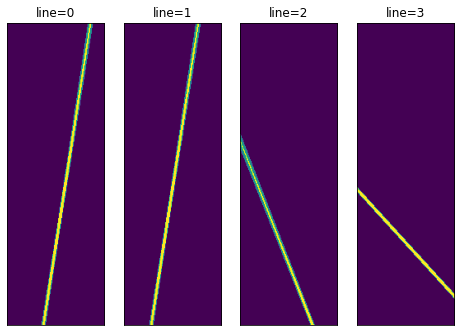

In [ ]:
corridor_lines = [corridor_line0,corridor_line1, corridor_line2, corridor_line3]
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(8,32))
axs = axs.ravel()
for i,ax in enumerate(axs):
    ax.tick_params(axis='both', which='both', **nolabels)
    ax.imshow(corridor_lines[i])
    ax.set_title(f'line={i}')
#
plt.show()

> Corridor 0 -> Line 0

In [ ]:
# corridor0 -> line 0
img_bf = corridor_line0
cellsize = 1

seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (img_bf, xyz_min, pts_0, cellsize)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 

# based on current points, to calculate the height range
# based on the height range, do second filter to remove noise points
a = pts_0[pids,2]
pts_line0 = pts_0[pids]
pts_buffer = pts_line0

dz = calOutlierByIQR(a)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
data = (img_bf, xyz_min, pts_0, cellsize, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids_0 = locatePointsFromBuffer_3D(**a)
pids_0 = np.unique(pids_0)
ids = list(lp_c0.dic.values())
ids = np.array(ids)
ids_0 = ids[pids_0]
#

a = {'img_buffer':img_bf, 'min_xyz': xyz_min, 'cellsize':cellsize, 
     'pts_target':pts_1, 'pts_buffer': pts_buffer,'zrange':[zmin,zmax]}
pids_1 = extractLineFromTarget(**a)
pids_1 = np.unique(pids_1)
ids = list(lp_c1.dic.values())
ids = np.array(ids)
ids_1 = ids[pids_1]
#
ids_line0 = ids_0.tolist() + ids_1.tolist()
print(len(np.unique(ids_line0)))
len(ids_line0)

11788


11788

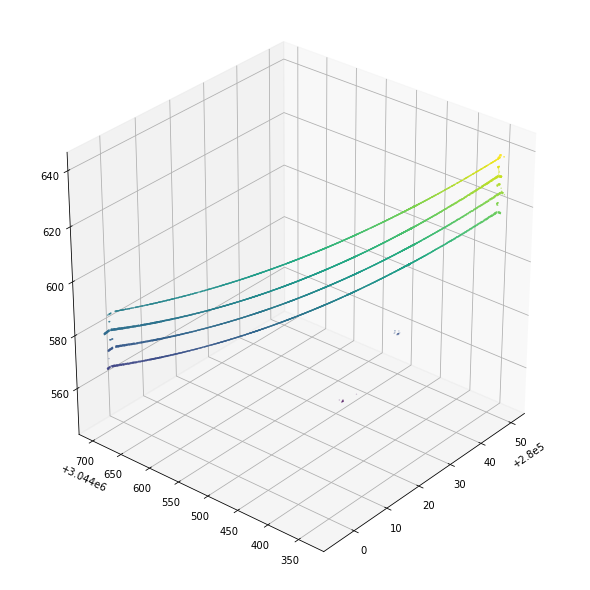

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz[ids_line0].T), s=0.1, c=rgb[ids_line0])
ax.view_init(azim = 180+40,elev = 30) 
plt.show()

> Corridor 1 -> Line 1

In [ ]:
img_bf = corridor_line1
cellsize = 1

seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (img_bf, xyz_min, pts_0, cellsize)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 

# based on current points, to calculate the height range
# based on the height range, do second filter to remove noise points
a = pts_0[pids,2]
#pts_line1 = pts_0[pids]
pts_buffer = pts_0[pids]

dz = calOutlierByIQR(a)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
data = (img_bf, xyz_min, pts_0, cellsize, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids_0 = locatePointsFromBuffer_3D(**a)
pids_0 = np.unique(pids_0)
ids = list(lp_c0.dic.values())
ids = np.array(ids)
ids_0 = ids[pids_0]
#

a = {'img_buffer':img_bf, 'min_xyz': xyz_min, 'cellsize':cellsize, 
     'pts_target':pts_1, 'pts_buffer': pts_buffer,'zrange':[zmin,zmax]}
pids_1 = extractLineFromTarget(**a)
pids_1 = np.unique(pids_1)
ids = list(lp_c1.dic.values())
ids = np.array(ids)
ids_1 = ids[pids_1]
#
ids_line1 = ids_0.tolist() + ids_1.tolist()
print(len(np.unique(ids_line1)))
len(ids_line1)

13954


13954

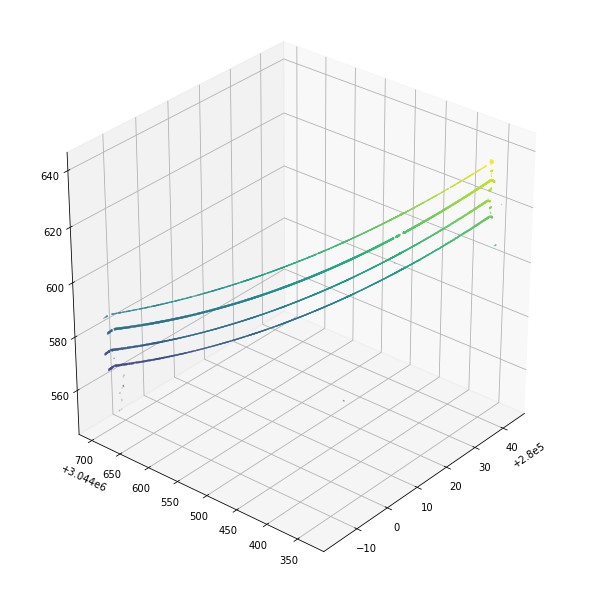

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz[ids_line1].T), s=0.1, c=rgb[ids_line1])
ax.view_init(azim = 180+40,elev = 30) 
plt.show()

> Corridor 2 -> Line 2

In [ ]:
img_bf = corridor_line2
cellsize = 1

seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (img_bf, xyz_min, pts_0, cellsize)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 

# based on current points, to calculate the height range
# based on the height range, do second filter to remove noise points
a = pts_0[pids,2]
#pts_line1 = pts_0[pids]
pts_buffer = pts_0[pids]

dz = calOutlierByIQR(a)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
zmin = max(zmin, min(a))
zmax = min(zmax, zmin+35)
data = (img_bf, xyz_min, pts_0, cellsize, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids_0 = locatePointsFromBuffer_3D(**a)
pids_0 = np.unique(pids_0)
ids = list(lp_c0.dic.values())
ids = np.array(ids)
ids_0 = ids[pids_0]
#

a = {'img_buffer':img_bf, 'min_xyz': xyz_min, 'cellsize':cellsize, 
     'pts_target':pts_1, 'pts_buffer': pts_buffer,'zrange':[zmin,zmax]}
pids_1 = extractLineFromTarget(**a)
pids_1 = np.unique(pids_1)
ids = list(lp_c1.dic.values())
ids = np.array(ids)
ids_1 = ids[pids_1]
#
ids_line2 = ids_0.tolist() + ids_1.tolist()
print(len(np.unique(ids_line2)))
len(ids_line2)

679


679

525.67 540.67
525.67


(1191, 3)

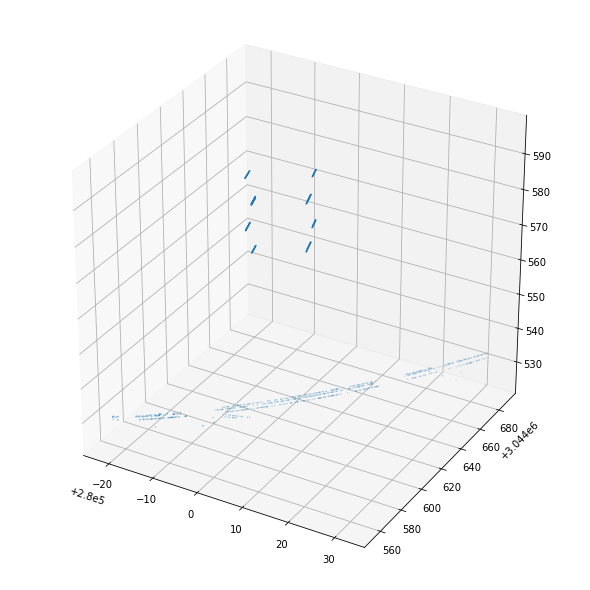

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(pts_buffer.T), s=0.1)
print(zmin, zmax)
print(min(pts_buffer[:,2]))
pts_buffer.shape

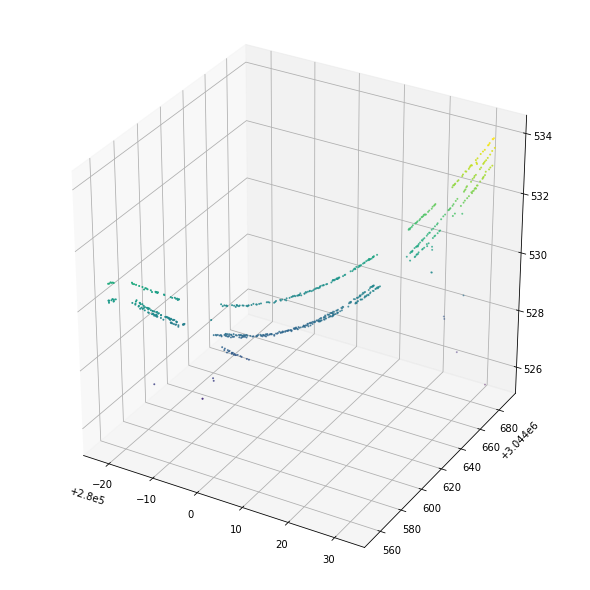

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz[ids_line2].T), s=1, c=rgb[ids_line2])
#ax.view_init(azim = 180+40,elev = 30) 
plt.show()

> Corridor 3 -> Line 3

In [ ]:
img_bf = corridor_line3
cellsize = 1

seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (img_bf, xyz_min, pts_0, cellsize)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 

# based on current points, to calculate the height range
# based on the height range, do second filter to remove noise points
a = pts_0[pids,2]
#pts_line1 = pts_0[pids]
pts_buffer = pts_0[pids]

dz = calOutlierByIQR(a)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
zmin = max(zmin, min(a))
zmax = min(zmax, zmin+35)
data = (img_bf, xyz_min, pts_0, cellsize, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids_0 = locatePointsFromBuffer_3D(**a)
pids_0 = np.unique(pids_0)
ids = list(lp_c0.dic.values())
ids = np.array(ids)
ids_0 = ids[pids_0]
#

a = {'img_buffer':img_bf, 'min_xyz': xyz_min, 'cellsize':cellsize, 
     'pts_target':pts_1, 'pts_buffer': pts_buffer,'zrange':[zmin,zmax]}
pids_1 = extractLineFromTarget(**a)
pids_1 = np.unique(pids_1)
ids = list(lp_c1.dic.values())
ids = np.array(ids)
ids_1 = ids[pids_1]
#
ids_line3 = ids_0.tolist() + ids_1.tolist()
print(len(np.unique(ids_line3)))
len(ids_line3)

206


206

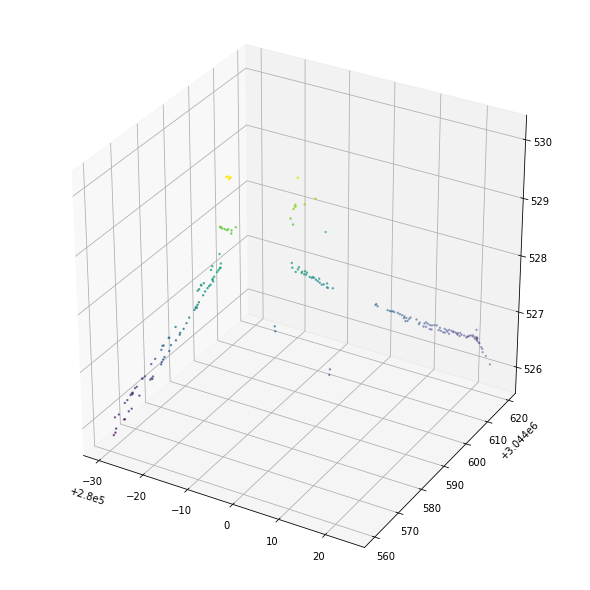

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz[ids_line3].T), s=2, c=rgb[ids_line3])
#ax.view_init(azim = 180+40,elev = 30) 
plt.show()

> Corridor all -> Line all

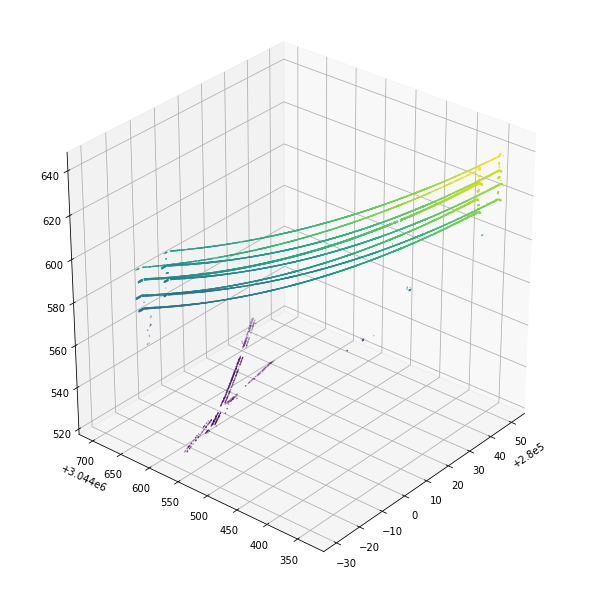

26598


In [ ]:
ids_all = ids_line0 + ids_line1+ ids_line2+ ids_line3
ids_all = np.unique(ids_all)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1], projection='3d')
ax.scatter(*(xyz[ids_all].T), s=0.1, c=rgb[ids_all])
ax.view_init(azim = 180+40,elev = 30) 
plt.show()

print(len(ids_all))